<a href="https://colab.research.google.com/github/KhushiAherwar/AppgitAction/blob/main/GraphRag_IndianHistory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 24.0 MB/s eta 0:00:00


In [2]:
# ================================
# Complete Colab-ready Graph-RAG pipeline
# ================================

# Install dependencies (run once)
# !pip install -q sentence-transformers faiss-cpu transformers accelerate datasets spacy networkx py2neo
# !python -m spacy download en_core_web_sm

# -------------------------
# Imports
# -------------------------
import os
from datasets import load_dataset, concatenate_datasets, Dataset
import spacy
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
import networkx as nx
from transformers import pipeline

# -------------------------
# Config
# -------------------------
SPACY_MODEL = "en_core_web_sm"
EMBED_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
LLM_MODEL = "google/flan-t5-base"
CHUNK_SIZE_WORDS = 200
CHUNK_OVERLAP = 50

# -------------------------
# 1) Load & preprocess datasets
# -------------------------
def load_and_preprocess_datasets():
    qna = load_dataset("BashitAli/Indian_history", split="train")
    dyn = load_dataset("chungimungi/Indian-History", split="train")

    def preprocess_qna(example):
        return {"text": (example.get("instruction","") + "\n" + example.get("response","")).strip()}

    def preprocess_dyn(example):
        combined = (example.get("system_prompt","") + "\n") if example.get("system_prompt") else ""
        combined += example.get("prompt","") + "\n" + example.get("completion","")
        return {"text": combined.strip()}

    qna = qna.map(preprocess_qna, remove_columns=qna.column_names)
    dyn = dyn.map(preprocess_dyn, remove_columns=dyn.column_names)

    def clean_text(example):
        txt = example["text"].strip()
        txt = " ".join(txt.split())
        return {"text": txt}

    qna = qna.map(clean_text).map(lambda x: {"source": "QnA"})
    dyn = dyn.map(clean_text).map(lambda x: {"source": "Dynasty"})

    corpus = concatenate_datasets([qna, dyn]).shuffle(seed=42)
    print(f"Loaded and merged corpus: {len(corpus)} records")
    return corpus

corpus = load_and_preprocess_datasets()

# -------------------------
# 2) Chunk the corpus
# -------------------------
def chunk_corpus(corpus: Dataset, chunk_size=CHUNK_SIZE_WORDS, overlap=CHUNK_OVERLAP) -> Dataset:
    all_chunks = []
    for ex in corpus:
        words = ex["text"].split()
        if len(words) == 0:
            continue
        for i in range(0, len(words), chunk_size - overlap):
            chunk = " ".join(words[i:i+chunk_size])
            all_chunks.append({"text": chunk, "source": ex["source"]})
    print(f"Chunked corpus into {len(all_chunks)} pieces")
    return Dataset.from_list(all_chunks)

chunked_corpus = chunk_corpus(corpus)

# -------------------------
# 3) Define KG + entity/relation extraction
# -------------------------
nlp = None

def ensure_spacy():
    global nlp
    if nlp is None:
        nlp = spacy.load(SPACY_MODEL)
    return nlp

def extract_entities_relations(text):
    nlp = ensure_spacy()
    doc = nlp(text)
    entities = list({ent.text for ent in doc.ents})
    relations = []
    for sent in doc.sents:
        subj, verb, obj = None, None, None
        for token in sent:
            if token.dep_.endswith("subj"): subj=token
            if token.pos_=="VERB": verb=token
            if token.dep_.endswith("obj"): obj=token
        if subj and verb and obj:
            subj_span = " ".join([t.text for t in subj.subtree])
            obj_span = " ".join([t.text for t in obj.subtree])
            relations.append((subj_span, verb.lemma_, obj_span))
    if not entities:
        entities = [token.text for token in doc if token.pos_ in ("PROPN","NOUN")][:2]
    return entities, relations

class KG:
    def __init__(self):
        self.nx = nx.DiGraph()

    def add_entity(self, name, props=None):
        if props is None: props={}
        if name not in self.nx: self.nx.add_node(name, **props)
        else: self.nx.nodes[name].update(props)

    def add_relation(self, subj, rel, obj):
        self.add_entity(subj)
        self.add_entity(obj)
        self.nx.add_edge(subj, obj, label=rel)

    def all_nodes(self):
        return list(self.nx.nodes)

    def neighbors(self, name):
        return [(nbr, self.nx[name][nbr].get('label','related')) for nbr in self.nx[name]]

    def set_node_prop(self, name, key, value):
        if name in self.nx: self.nx.nodes[name][key] = value

def build_kg(chunked: Dataset, kg: KG, limit=None):
    count = 0
    for ex in chunked:
        ents, rels = extract_entities_relations(ex['text'])
        for e in ents:
            if e.strip(): kg.add_entity(e)
        for s,v,o in rels:
            if s.strip() and o.strip(): kg.add_relation(s,v,o)
        count += 1
        if limit and count>=limit: break
    print(f"KG built from {count} chunks. Total nodes: {len(kg.all_nodes())}")

# -------------------------
# 4) Build KG
# -------------------------
kg = KG()
build_kg(chunked_corpus, kg, limit=None)

# -------------------------
# 5) Compute embeddings + FAISS
# -------------------------
embed_model = SentenceTransformer(EMBED_MODEL_NAME)
node_names = kg.all_nodes()
node_embeddings = embed_model.encode(node_names, convert_to_numpy=True, normalize_embeddings=True)
for name, emb in zip(node_names, node_embeddings):
    kg.set_node_prop(name, 'embedding', emb)

dim = node_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(dim)
faiss_index.add(node_embeddings)

# -------------------------
# 6) Retrieval function
# -------------------------
def retrieve(query, kg, faiss_index, node_names, top_k=3):
    q_emb = embed_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    D,I = faiss_index.search(q_emb, top_k)
    retrieved_nodes = [node_names[i] for i in I[0]]
    expanded = set(retrieved_nodes)
    for node in retrieved_nodes:
        for nbr,_ in kg.neighbors(node): expanded.add(nbr)
    return list(expanded)

# -------------------------
# 7) LLM generation
# -------------------------
generator = pipeline("text2text-generation", model=LLM_MODEL, device_map="auto")

query = "Who founded the Mughal Empire in India?"
retrieved_nodes = retrieve(query, kg, faiss_index, node_names, top_k=3)
context_text = " ".join(retrieved_nodes)
answer = generator(f"Question: {query} Context: {context_text}", max_length=200)

print("Retrieved nodes:", retrieved_nodes)
print("Answer:", answer[0]['generated_text'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

datasetfile.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14908 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/152k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/14908 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/14908 [00:00<?, ? examples/s]

Map:   0%|          | 0/14908 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Loaded and merged corpus: 15008 records
Chunked corpus into 15271 pieces
KG built from 15271 chunks. Total nodes: 23610


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Retrieved nodes: ['The First Mughal Empire', 'the First Mughal Empire', 'the establishment of the Mughal Empire', '1556', 'regional states']
Answer: The First Mughal Empire


In [3]:
print("Nodes:", len(kg.all_nodes()))
for node in kg.all_nodes()[:10]:
    print(node, "→", kg.neighbors(node))


Nodes: 23610
Indus Valley → []
the urban civilization of the Indus Valley → [('the Indus Valley', 'suggest')]
the Indus Valley → []
people → [('the time', 'live'), ('social and political issues', 'respond'), ('the Upnishads', 'recommend'), ('mourning', 'fast'), ('work and opportunities', 'move'), ('statues', 'worship'), ('four main groups : Brahmins ( priests and scholars ) , Kshatriyas ( warriors and rulers ) , Vaishyas ( merchants and traders ) , and Shudras ( labourers )', 'divide'), ('religion', 'accord'), ('gifts', 'make'), ('Buddhist and Jaina', 'think'), ('agriculture', 'engage'), ('the times', 'pray'), ('nationalism', 'regard'), ('big powers', 'oppose'), ('their liberation campaigns', 'place'), ('foreign goods', 'sell'), ('societal and policy matters', 'gain'), ('confusion and chaos', 'lead'), ('brave and skillful warriors', 'choose'), ('the text', 'accord'), ('what', 'consider'), ('financial chaos', 'cause'), ('partition', 'express'), ('important matters', 'express'), ('animal

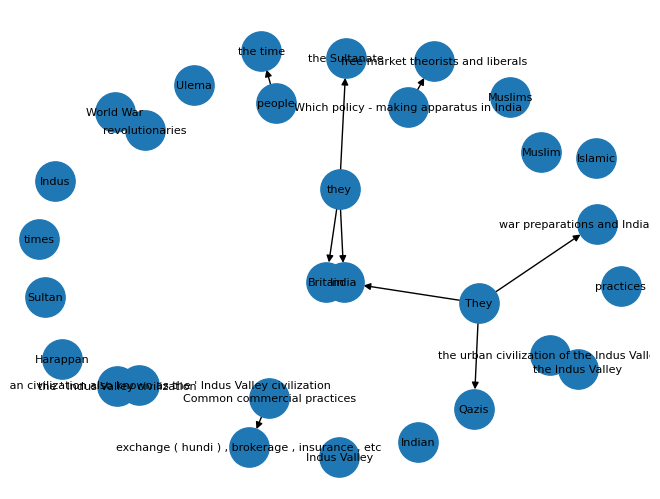

In [4]:
import matplotlib.pyplot as plt
subgraph = kg.nx.subgraph(kg.all_nodes()[:30])
nx.draw(subgraph, with_labels=True, node_size=800, font_size=8)
plt.show()


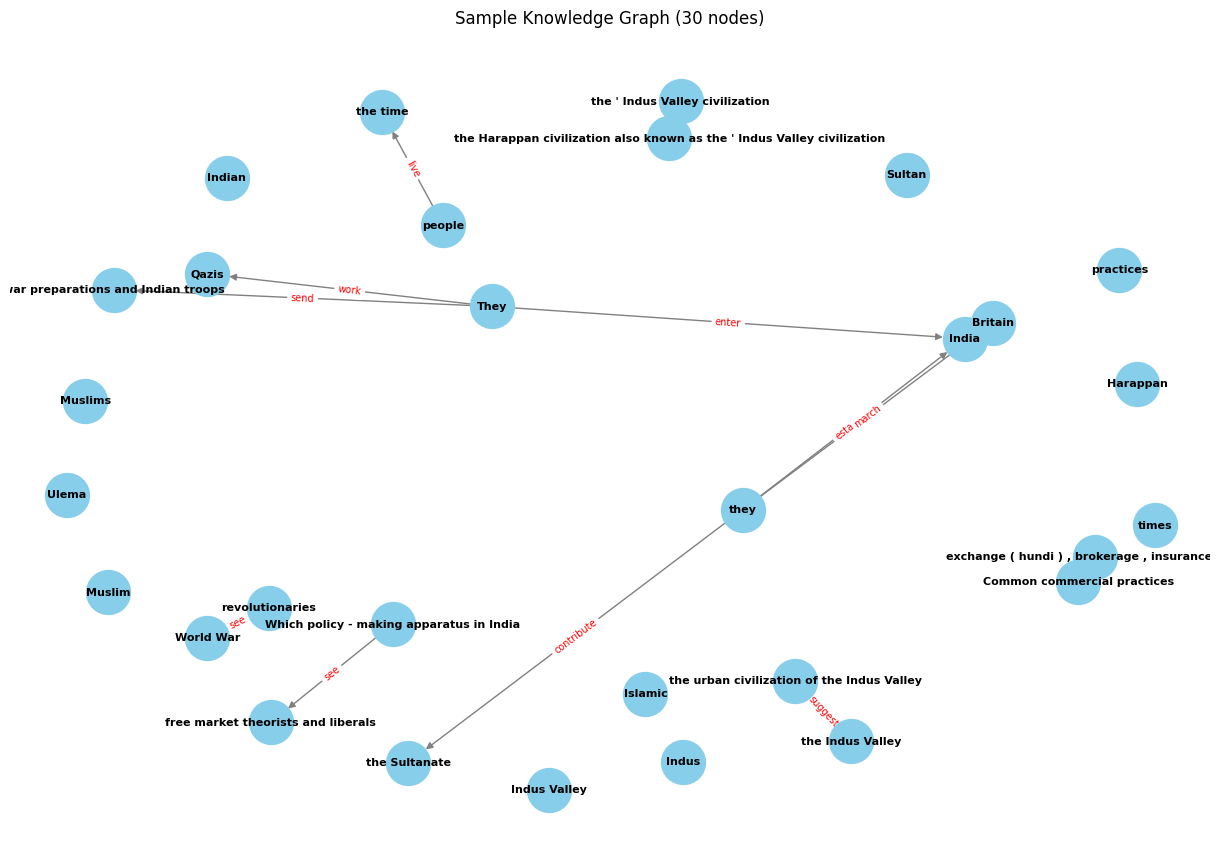

In [5]:
import matplotlib.pyplot as plt

# Take a small subset of nodes to avoid clutter
sample_nodes = node_names[:30]  # first 30 nodes
subgraph = kg.nx.subgraph(sample_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # force-directed layout
nx.draw(subgraph, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=8, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(subgraph, 'label')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=7)
plt.title("Sample Knowledge Graph (30 nodes)")
plt.show()


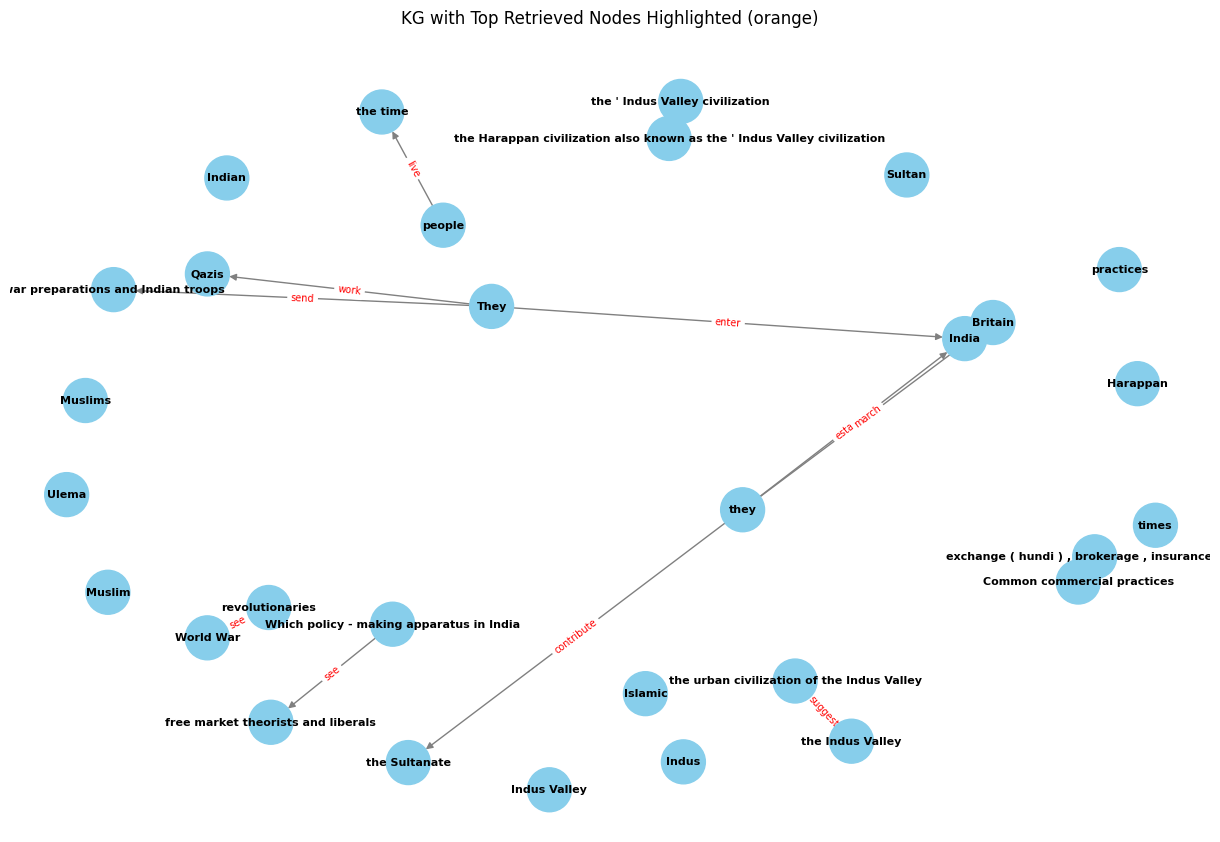

In [6]:
query_nodes = retrieved_nodes[:10]  # top retrieved nodes

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)
node_colors = ['orange' if n in query_nodes else 'skyblue' for n in subgraph.nodes]
nx.draw(subgraph, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=8, font_weight='bold', edge_color='gray')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=nx.get_edge_attributes(subgraph, 'label'), font_color='red', font_size=7)
plt.title("KG with Top Retrieved Nodes Highlighted (orange)")
plt.show()


Explanation:

Highlights nodes that were retrieved for the current query in orange.

Provides a visual idea of which parts of the KG the RAG system is using.

In [7]:

import gradio as gr

def gradio_qa_safe(query):
    if not query.strip():
        return "No query provided", ""

    # Retrieve KG nodes safely
    retrieved_nodes = retrieve(query, kg, faiss_index, node_names, top_k=3)
    if not retrieved_nodes:
        return "No relevant nodes found", ""

    context_text = " ".join(retrieved_nodes)

    prompt = f"Question: {query}\nContext: {context_text}"

    try:
        # Ensure CPU fallback if GPU is not available
        output = generator(prompt, max_length=200)
        answer = output[0]['generated_text']
    except Exception as e:
        answer = f"Error generating answer: {str(e)}"

    return ", ".join(retrieved_nodes), answer

# Launch Gradio
iface = gr.Interface(
    fn=gradio_qa_safe,
    inputs=gr.Textbox(lines=2, placeholder="Ask a question about Indian history..."),
    outputs=[
        gr.Textbox(label="Retrieved KG Nodes"),
        gr.Textbox(label="Answer")
    ],
    title="Graph-RAG QA (Colab Safe)",
    description="Ask questions about Indian history. Retrieved KG nodes + LLM answer."
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9d85dac67abea6cb62.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
